In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os

In [2]:
filename = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname('treinamento.txt'))) + '/treinamento-1.txt'
series = pandas.read_csv(filename,  header=None)

In [3]:
def series_to_supervised(df, n_lags, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a pandas dataframe.
        n_lags: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lags, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
D = series_to_supervised(series, 21).values

X = D[:,0:-1]
Y = D[:,-1].reshape(X.shape[0],1)

train_size = round(X.shape[0] * 0.7)
test_size = X.shape[0] - train_size
Xtr = X[0:train_size,:]
Xv = X[train_size:train_size+test_size,:]
Ytr = Y[0:train_size,:]
Yv = Y[train_size:train_size+test_size,:]

In [32]:
hidden_units=7

In [33]:
def sigmoid(Z):
    return 1 / (1+np.exp(-Z))

In [34]:
def calc_saida(X,Y,W1,W2,N):
    Z1 = np.dot(X,W1.T)
    ##tanh
    A1 = (np.exp(Z1) - np.exp(-Z1)) / (np.exp(Z1)+np.exp(-Z1))
    ##add bias
    A1 = np.concatenate((A1, np.ones((N,1))), axis=1)
    
    Z2 = np.dot(A1,W2.T)
    A2 = Z2
    
    erro = A2 - Y
    
    return A1,A2,erro

In [35]:
def grad(X,Y,W1,W2,N):
    A1,A2,erro = calc_saida(X,Y,W1,W2,N)

    nh = W2.shape[1] - 1
    ns = Y.shape[1]
    
    dC_dAj = erro
    dAj_dZi = 1

    dC_Z2 =  dC_dAj * dAj_dZi
    
    dW2 = 1/N * np.dot(dC_Z2.T , A1)
    dW1 = 1/N * np.dot((np.dot(dC_Z2, W2[:,:nh]) * (1-(A1[:,:nh] * A1[:,:nh]))).T , X)
    return dW2, dW1

In [36]:
def perceptron(X,Y,alfa,nepocasmax,hidden_units):
    
    N = Y.shape[0]
    ns = Y.shape[1]
    nh = hidden_units

    ##add bias
    X = np.concatenate((X, np.ones((N,1))), axis=1)

    ne = X.shape[1]
    W1 = np.random.rand(nh,ne)/5
    W2 = np.random.rand(ns,nh+1)/5


    ##Calcula saida
    A1,A2,erro = calc_saida(X,Y,W1,W2,N)
    EQM = 1/N * np.sum(erro*erro)
    

    nval=0
    vet_erro = np.array([EQM])
    new_vet = vet_erro 
    nepocas=0
    alfa=1    
    
    while EQM>1e-4 and nepocas<nepocasmax:
        nepocas = nepocas + 1;
        dW2,dW1=grad(X,Y,W1,W2,N)
    
        W1 = W1 - (alfa * dW1)
        W2 = W2 - (alfa * dW2)

        A1,A2,erro = calc_saida(X,Y,W1,W2,N)
        EQM = 1/N * np.sum(erro*erro)
        new_vet = np.append(new_vet,EQM)

                
                
    plt.plot(new_vet)
    plt.ylabel('Error evolution')
    plt.show()

    return W1, W2, new_vet

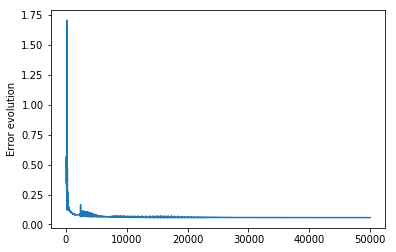

In [37]:
W1,W2,vet_erro=perceptron(Xtr,Ytr,0.1,50000,hidden_units)

In [24]:
vet_erro[-1]

0.11673436005690203

In [27]:
Nv = Yv.shape[0]

##add bias
Xv = np.concatenate((Xv, np.ones((Nv,1))), axis=1)

##Calcula saida
A1v,A2v,errov = calc_saida(Xv,Yv,W1,W2,Nv)
EQMv = 1/Nv * np.sum(errov*errov)

In [28]:
EQMv

0.1663181481032822

In [29]:
np.round(A2v,2)

array([[ 0.99],
       [-0.47],
       [ 0.84],
       [-0.42],
       [ 0.72],
       [-0.39],
       [ 0.54],
       [-0.33],
       [ 0.56],
       [ 0.65],
       [ 0.24],
       [ 1.07],
       [-0.4 ],
       [-0.91],
       [-0.83],
       [-0.31],
       [ 0.21],
       [ 1.03],
       [-0.59],
       [-0.9 ],
       [-0.81],
       [-0.24],
       [ 0.67],
       [ 0.72],
       [ 0.43],
       [ 0.99],
       [-0.02],
       [ 0.94],
       [-0.25],
       [ 0.87],
       [ 0.05],
       [ 0.75],
       [ 0.39],
       [ 1.  ],
       [-0.36],
       [-0.56],
       [ 0.4 ],
       [ 0.73],
       [ 0.41],
       [ 1.  ],
       [-0.09],
       [ 0.84],
       [-0.11],
       [ 1.18],
       [-0.38],
       [-0.71],
       [ 0.01],
       [ 1.02],
       [-0.31],
       [-0.45],
       [-0.29],
       [ 0.65],
       [ 0.33],
       [ 0.46],
       [ 0.8 ],
       [ 0.34],
       [ 0.16],
       [ 0.06],
       [ 0.58],
       [ 0.2 ],
       [ 0.43],
       [ 0.19],
       [

In [30]:
Yv

array([[ 0.6019081],
       [-0.6992859],
       [ 0.699651 ],
       [-0.6319539],
       [ 0.8119542],
       [-0.8726618],
       [ 0.9397416],
       [-0.8332047],
       [-0.3884601],
       [ 0.6981976],
       [ 0.0250403],
       [ 0.998746 ],
       [-0.994987 ],
       [-0.9799983],
       [-0.9207932],
       [-0.6957203],
       [ 0.0319465],
       [ 0.9979588],
       [-0.9918437],
       [-0.967508 ],
       [-0.8721433],
       [-0.5212678],
       [ 0.4565597],
       [ 0.5831065],
       [ 0.3199737],
       [ 0.7952337],
       [-0.2647933],
       [ 0.859769 ],
       [-0.4784054],
       [ 0.5422565],
       [ 0.4119157],
       [ 0.6606509],
       [ 0.1270808],
       [ 0.9677009],
       [-0.8728902],
       [-0.5238745],
       [ 0.451111 ],
       [ 0.5929977],
       [ 0.2967074],
       [ 0.8239295],
       [-0.3577196],
       [ 0.7440734],
       [-0.1072906],
       [ 0.9769775],
       [-0.9089699],
       [-0.6524527],
       [ 0.1486109],
       [ 0.95

In [38]:
W1

array([[-7.17330676e-01, -3.41205933e-01,  5.07344363e-01,
         1.48234002e-01, -5.03509525e-01, -8.20225461e-01,
         1.07111389e+00,  9.72566761e-01, -6.01843386e-01,
         1.10945951e+00,  2.05093696e-01,  3.86804981e-01,
         2.85757466e-02,  2.24243285e+00, -1.30220777e+00,
         5.06198178e-01, -8.23083080e-01,  4.12959278e-01,
        -5.95902899e-01, -1.64721884e-01, -9.98064103e-01,
        -6.13984864e-01],
       [ 2.84016078e-02, -8.34847963e-01, -2.79479805e-01,
        -1.34585018e+00,  7.21024574e-01,  1.41242522e+00,
         4.80621160e-02, -3.15145547e-01, -4.44407607e-01,
        -6.02636699e-01, -5.24718209e-01,  3.27705269e+00,
         5.09182555e-02, -1.67501330e+00,  3.82834161e-01,
         1.68399259e+00, -1.74529141e+00,  3.82732823e-01,
         2.43230400e+00,  5.71942296e-01,  2.19631917e+00,
        -2.66911047e-01],
       [ 3.83273162e-01,  7.05968255e-01, -4.43535925e-01,
        -2.47313860e-01,  1.99707898e-01,  4.76959283e-01,
    

In [39]:
W2

array([[-0.27193761, -0.19045656,  0.45132895,  1.0433257 , -0.28607785,
         0.23339001,  1.10812958, -1.08195182]])